## Exploratory Data Analysis (EDA)

Este notebook apresenta a análise exploratória realizada no conjunto de dados de treinamento para o problema de identificação de Fake News, problema abordado nesse projeto.

#### Versão do Python:

In [1]:
from platform import python_version

print('Versão do Python: ' + python_version())

Versão do Python: 3.7.1


#### Importação de bibliotecas:

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import * 
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# baixar na primeira execução
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prisk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prisk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Visão geral do conjunto de treinamento:

In [3]:
# read datasets
train = pd.read_csv('dataset/train.csv', encoding='utf-8')
print("Existem {} exemplo, no dataset de treinamento. Cada exemplo contém {} atributos, sendo: "
      .format(train.shape[0],train.shape[1]) + ", ".join(train.columns) + '.')

Existem 20800 exemplo, no dataset de treinamento. Cada exemplo contém 5 atributos, sendo: id, title, author, text, label.


In [4]:
# visualização das 5 primeiras notícias do conjunto de dados
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


In [5]:
# informações adicionais sobre o conjunto de treinamento
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
id        20800 non-null int64
title     20242 non-null object
author    18843 non-null object
text      20761 non-null object
label     20800 non-null int64
dtypes: int64(2), object(3)
memory usage: 568.8+ KB


In [6]:
print('Existem {} exemplos onde o atributo title é nulo.'.format(len(train[train['title'].isnull()])))
print('Existem {} exemplos onde o atributo author é nulo.'.format(len(train[train['author'].isnull()])))
print('Existem {} exemplos onde o atributo text é nulo.'.format(len(train[train['text'].isnull()])))

Existem 558 exemplos onde o atributo title é nulo.
Existem 1957 exemplos onde o atributo author é nulo.
Existem 39 exemplos onde o atributo text é nulo.


Como é possível notar acima, existem 39 casos em que o texto da reportagem é nulo. Esses casos serão removidos do conjunto de treinamento.

In [7]:
# remover exemplos com texto vazio
train = train[~train['text'].isnull()]
train.shape

(20761, 5)

Os 558 casos em que o atributo title é nulo serão mantidos, pois a informação principal é o texto da notícia. Esses valores nulos serão preenchidos com uma string vazia

In [8]:
train.fillna('',inplace=True)

Existem alguns registros de matérias escritas em outros idiomas e com outros alfabetos. Essas matérias serão removidas.
O código abaixo foi obtido no stackoverflow: https://stackoverflow.com/questions/3094498/how-can-i-check-if-a-python-unicode-string-contains-non-western-letters

In [9]:
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

In [10]:
train['only_roman_chars'] = train['text'].apply(only_roman_chars)
# remover exemplos com texto em outros alfabetos
train = train[train['only_roman_chars']==True]
train.shape

(20478, 6)

In [11]:
print("Existem {} textos únicos no conjunto de dados, sendo assim {} duplicados. Esses exemplos duplicados serão removidos,\
 sendo mantido o primeiro exemplo de cada item duplicado."
     .format(len(train['text'].unique()),len(train['text'])-len(train['text'].unique())))
train.drop_duplicates(subset=['text'],inplace=True)

Existem 20103 textos únicos no conjunto de dados, sendo assim 375 duplicados. Esses exemplos duplicados serão removidos, sendo mantido o primeiro exemplo de cada item duplicado.


In [12]:
print("Com relação à variável resposta, temos {} possíveis respostas. Conforme descrito na proposta desse projeto, \
esse problema é de classificação binária, tendo como objetivo identificar notícias confiáveis \
(representadas pela label 1) e não confiáveis (representadas pela label 0). A distribuição de exemplos em cada classe \
está na tabela abaixo.".format(len(train.label.unique())))


Com relação à variável resposta, temos 2 possíveis respostas. Conforme descrito na proposta desse projeto, esse problema é de classificação binária, tendo como objetivo identificar notícias confiáveis (representadas pela label 1) e não confiáveis (representadas pela label 0). A distribuição de exemplos em cada classe está na tabela abaixo.


In [13]:
# descreve a quantidade de notícias por classe e a proporção que ela representa no conjunto de dados
pd.concat([train['label'].value_counts(),train['label'].value_counts(normalize=True)*100], axis=1, keys=['qtd', '%'])

,qtd,%
0,10360,51.534597
1,9743,48.465403


A partir da tabela acima é possível concluir que o conjunto de dados é balanceado.

In [15]:
print("Também é possível identificar que existem ao todo {} autores de \
notícias no conjunto de treinamento.".format(len(train.author.unique())))

Também é possível identificar que existem ao todo 4154 autores de notícias no conjunto de treinamento.


A tabela abaixo contém os nomes dos autores com mais de 100 notícias escritas. Na segunda posição é possível identificar "admin" como autor, o que indica que existem 193 notícias cujos autores podem ser diferentes, pois o dado aparenta estar faltando.

In [16]:
grouped = train.groupby('author')['id'].agg(['count']).reset_index()
grouped[grouped['count']>=100].sort_values('count', ascending=False)

,author,count
0,,1710
2929,Pam Key,243
3899,admin,188
1751,Jerome Hudson,163
718,Charlie Spiering,141
1846,John Hayward,140
2078,Katherine Rodriguez,124
3817,Warner Todd Huston,122
1510,Ian Hanchett,119
573,Breitbart News,118


É possível também analisar os autores que possuem mais notícias confiáveis e aqueles que possuem mais notícias não confiáveis, conforme apresentado nas tabelas abaixo

In [17]:
trust_grouped = train[train['label']==1].groupby('author')['id'].agg(['count']).reset_index()
trust_grouped.sort_values('count', ascending=False)[:10]

,author,count
0,,1684
1683,admin,188
1455,Starkman,84
58,Alex Ansary,82
624,Gillian,81
1833,noreply@blogger.com (Alexander Light),80
519,Editor,80
518,Eddy Lavine,79
429,Dave Hodges,76
701,IWB,73


In [18]:
nottrust_grouped = train[train['label']==0].groupby('author')['id'].agg(['count']).reset_index()
nottrust_grouped.sort_values('count', ascending=False)[:10]

,author,count
1731,Pam Key,242
950,Jerome Hudson,163
388,Charlie Spiering,141
998,John Hayward,140
1156,Katherine Rodriguez,124
2189,Warner Todd Huston,122
809,Ian Hanchett,119
312,Breitbart News,118
492,Daniel Nussbaum,110
910,Jeff Poor,107


Novamente houve destaque para o autor identificado como admin, sendo o que possui todos os artigos considerados confiáveis e é também o que mais possui artigos confiáveis.
Por outro lado, todos os demais autores com mais artigos escritos são também os autores com mais artigos não confiáveis.

Como variáveis adicionais, serão criadas colunas de quantidade de palavras originais, isto é, antes da etapa de pré-processamento.

In [19]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train['title_word_count'] = train['title'].apply(lambda x: len(str(x).split()))
train.head()

,id,title,author,text,label,only_roman_chars,word_count,title_word_count
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,True,820,14
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,True,710,9
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,True,1266,7
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,True,557,10
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1,True,154,14


### Tratamento dos dados
Nessa etapa será realizado o tratamento inicial dos dados para possibilitar outras análises exploratórias.

##### Conversão para minúsculas

In [20]:
train['processed_text'] = train['text'].str.lower()
train['processed_title'] = train['title'].str.lower()

##### Tokenização do texto e título

Após a conversão para minúsculas, será feita a tokenização dos dados, ou seja, a transformação do texto em uma lista de palavras

In [21]:
train['processed_text'] = train['processed_text'].apply(lambda x:list(nltk.word_tokenize(x)))
train['processed_title'] = train['processed_title'].apply(lambda x:list(nltk.word_tokenize(x)))

##### Remoção de números, caracteres especiais e stop_words
É necessário realizar uma limpeza no texto para igualar palavras iguais que podem ter sido escritas de forma incorreta ou diferente, palavras que não tem sentido sozinhos como números. Para isso faremos:
- remoção de caracteres numéricos
- remoção de caracteres especiais e pontuação
- remoção de acentos, hífens, apóstrofo
- remoção de stopwords
- stemming
- lematização

In [22]:
# retira os caracteres numéricos 
train['processed_text'] = train['processed_text'].apply(lambda x: [re.sub('[0-9]', '',i) for i in x])
train['processed_title'] = train['processed_title'].apply(lambda x: [re.sub('[0-9]', '',i) for i in x])

In [23]:
# retira os caracteres especiais e pontuação
train['processed_text'] = train['processed_text'].apply(lambda x: [re.sub('[?_!%&/.,®€™():]', '',i) for i in x])
train['processed_title'] = train['processed_title'].apply(lambda x: [re.sub('[?_!%&/.,®€™():]', '',i) for i in x])
train['processed_text'] = train['processed_text'].apply(lambda x: [i.replace("\\r", "").replace("\\n","") for i in x])
train['processed_title'] = train['processed_title'].apply(lambda x: [i.replace("\\r", "").replace("\\n","") for i in x])

In [24]:
# remove hífen e apóstrofo, adicionando espaço no lugar
train['processed_text'] = train['processed_text'].apply(lambda x: [re.sub('[-“”[—‘’\']', ' ',i) for i in x])
train['processed_title'] = train['processed_title'].apply(lambda x: [re.sub('[-“”[—‘’\']', ' ',i) for i in x])

In [25]:
# remoção de acentos
train['processed_text'] = train['processed_text'].apply(lambda x: [i.replace('â', "a").replace('è', 'e').replace('é', 'e').replace('í', 'i').replace('î', 'i').replace('ú', 'u').replace('ç', 'c') for i in x])
train['processed_title'] = train['processed_title'].apply(lambda x: [i.replace('â', "a").replace('è', 'e').replace('é', 'e').replace('í', 'i').replace('î', 'i').replace('ú', 'u').replace('ç', 'c') for i in x])

Além da limpeza do texto, é necessário remover stopwords como: and, a, an. Como os textos e títulos estão escritos em inglês, serão removidas as stopwords da linha inglesa:

In [26]:
# lista de stopwords em inglês
stop_words = set(stopwords.words('english')) 
stop_words 

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Nesse momento, além de realizar a remoção das stopwords, é realizada a conversão dos textos e títulos do formato string para o formato de array: 

In [27]:
train['processed_text'] = train['processed_text'].apply(lambda x: [item for item in x if item not in stop_words])
train['processed_title'] = train['processed_title'].apply(lambda x: [item for item in x if item not in stop_words])

##### Lematização

A lematização é um processo que identifica o "lema" de uma palavra, ou seja, o significado central de uma palavra. Aplicado nesse problema, a lematização irá, por exemplo, transformar as palavras que estão no plural para o singular.

In [28]:
lemmatizer = nltk.stem.WordNetLemmatizer()
train['processed_text'] = train['processed_text'].apply(lambda x:  [lemmatizer.lemmatize(w) for w in x])
train['processed_title'] = train['processed_title'].apply(lambda x:  [lemmatizer.lemmatize(w) for w in x])

##### Stemming

Esse processo identifica o radical de uma palavra. Por exemplo, para as palavras: program, programming, programer; o processo de stemming retorna program para todas elas

In [29]:
stemmer = PorterStemmer()  
train['processed_text'] = train['processed_text'].apply(lambda x:  [stemmer.stem(i) for i in x])
train['processed_title'] = train['processed_title'].apply(lambda x:  [stemmer.stem(i) for i in x])

##### Remoção de palavras vazias

Por conta dos tratamentos realizadas, algumas palavras no array de palavras ficou com espaço em branco, ou seja, uma palavra vazia. O código abaixo remove essas ocorrências:

In [30]:
train['processed_text'] = train['processed_text'].apply(lambda x: [a.strip() for a in x if a.strip()])
train['processed_title'] = train['processed_title'].apply(lambda x: [a.strip() for a in x if a.strip()])

## Análises exploratórias

Com base na coluna de texto e título processado, serão criadas variáveis de quantidade de palavras para cada uma delas.

In [31]:
train['processed_word_count'] = train['processed_text'].apply(lambda x: len(x))
train['processed_title_word_count'] = train['processed_title'].apply(lambda x: len(x))

In [32]:
# removendo textos que ficaram vazios após o tratamento e limpeza
train = train[train['processed_word_count']!=0]

#### Comparação da quantidade de palavras antes e depois do tratamento

Análise da distribuição da quantidade de palavras para o texto e título das matérias, antes e depois de ser processado. E, após o processamento, considerando também a classe: "Confiável" ou "Não Confiável"

In [33]:
# visão geral das distribuições da quantidade de palavras presentes nos textos
train['processed_word_count'].describe()

count    20098.000000
mean       424.373271
std        455.928874
min          1.000000
25%        158.000000
50%        320.000000
75%        584.000000
max      12149.000000
Name: processed_word_count, dtype: float64

In [34]:
# visão geral das distribuições da quantidade de palavras presentes nos títulos
train['processed_title_word_count'].describe()

count    20098.000000
mean         8.459299
std          3.058170
min          0.000000
25%          7.000000
50%          9.000000
75%         10.000000
max         47.000000
Name: processed_title_word_count, dtype: float64

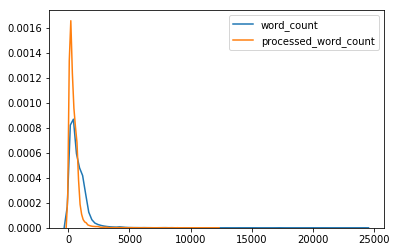

In [35]:
# Comparação das distribuições de quantidades de palavras (word_count) para o texto, antes e depois de processado
sns.kdeplot(train['word_count'])
sns.kdeplot(train['processed_word_count'])

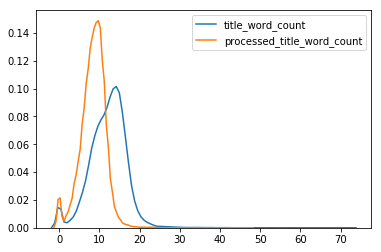

In [36]:
# Comparação das distribuições de quantidades de palavras (word_count) para o título, antes e depois de processado
sns.kdeplot(train['title_word_count'])
sns.kdeplot(train['processed_title_word_count'])

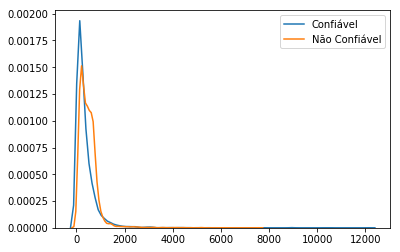

In [37]:
# Comparação das distribuições de quantidades de palavras (word_count) para o texto, após processado,
# considerando a classe que ele possui: Confiável ou não confiável
sns.kdeplot(train[train['label']==1]['processed_word_count'], label='Confiável')
sns.kdeplot(train[train['label']==0]['processed_word_count'], label='Não Confiável')

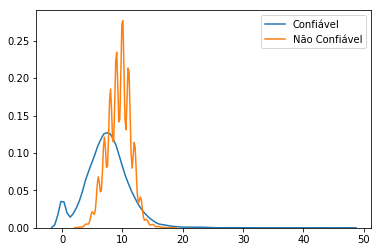

In [38]:
# Comparação das distribuições de quantidades de palavras (word_count) para o texto, após processado,
# considerando a classe que ele possui: Confiável ou não confiável
sns.kdeplot(train[train['label']==1]['processed_title_word_count'], label='Confiável')
sns.kdeplot(train[train['label']==0]['processed_title_word_count'], label='Não Confiável')

As análises de distribuição de quantidade de palavras não é significativa para identificar comportamentos distintos entre as classes "Confiável" e "Não Confiável".

#### Análise de Outliers

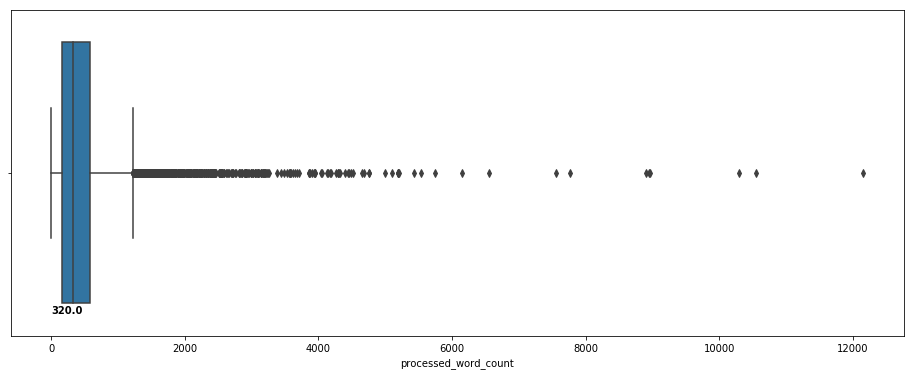

In [39]:
# plota o boxplot geral da quantidade de palavras no texto
plt.figure(figsize=(16, 6))
sns.boxplot(train['processed_word_count'])
median = str(np.round(train['processed_word_count'].median(),2))
plt.text(0, 0.43, median, weight='semibold')
plt.show()

A mediana do tamanho dos textos presentes no conjunto de treinamento é bem pequena: 327 palavras. De acordo com o boxplot acima, receitas com mais de 600 palavras são consideradas _outliers_.

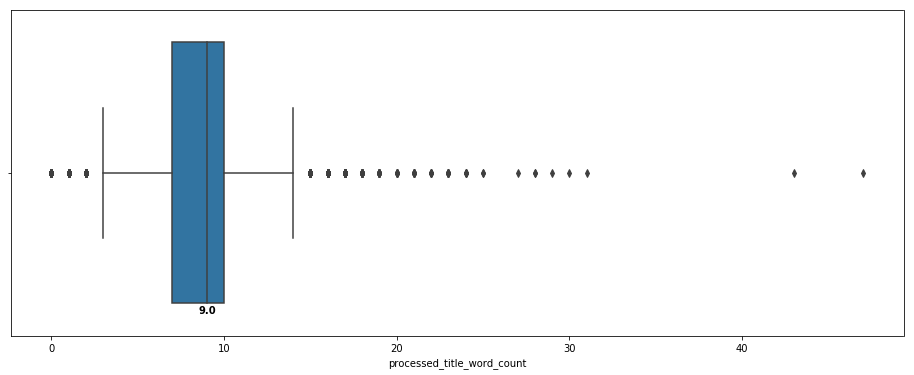

In [40]:
# plota o boxplot geral da quantidade de palavras no título
plt.figure(figsize=(16, 6))
sns.boxplot(train['processed_title_word_count'])
median = str(np.round(train['processed_title_word_count'].median(),2))
plt.text(8.5, 0.43, median, weight='semibold')
plt.show()

A mediana do tamanho dos títulos presentes no conjunto de treinamento é de 9 palavras. Para essa variável, títulos com nenhuma palavra são considerados _outliers_.

#### Notícias duplicadas
Para facilitar essa análise, será re-criada a variável texto a partir do texto processado, separando as palavras por vírgula.

In [41]:
# cria variável de texto, com palavras separadas por vírgula
train["words_text"] = train["processed_text"].apply(lambda x: ", ".join(x))

# encontrando casos duplicados
train[train.duplicated(subset=['words_text'], keep=False)]

,id,title,author,text,label,only_roman_chars,word_count,title_word_count,processed_text,processed_title,processed_word_count,processed_title_word_count,words_text
63,63,"Massive Anti-Trump Protests, Union Square NYC ...",Truth Broadcast Network,17 mins ago 2 Views 0 Comments 0 Likes New Z...,1,True,178,8,"[min, ago, view, comment, like, new, zealand, ...","[massiv, anti trump, protest, union, squar, ny...",193,8,"min, ago, view, comment, like, new, zealand, s..."
71,71,Treason! NYT vows 'rededication' to reporting!,Ivan the Stakhanovets,"In Hillary's America, email server scrubs you ...",1,True,4282,6,"[hillari, s, america, email, server, scrub, ob...","[treason, nyt, vow, reded, report]",3097,5,"hillari, s, america, email, server, scrub, oba..."
235,235,‘Sunk Costs’: $58 Billion Wasted On Imaginary ...,,Get short URL 0 37 0 0 A new government report...,1,True,228,10,"[get, short, url, new, govern, report, releas,...","[sunk, cost, $, billion, wast, imaginari, weap...",138,8,"get, short, url, new, govern, report, releas, ..."
532,532,"2,700-year-old Hebrew mention of Jerusalem found",-NO AUTHOR-,"2,700-year-old Hebrew mention of Jerusalem fou...",1,True,142,6,"[year old, hebrew, mention, jerusalem, found, ...","[year old, hebrew, mention, jerusalem, found]",82,5,"year old, hebrew, mention, jerusalem, found, r..."
826,826,"Syrian War Report – November 14, 2016: Govt Fo...",The Saker,Leave a Reply Click here to get more info on f...,1,True,335,17,"[leav, repli, click, get, info, format, leav, ...","[syrian, war, report, –, novemb, govt, forc, r...",221,13,"leav, repli, click, get, info, format, leav, n..."
1143,1143,"Meteor, space junk, rocket? Mysterious flash h...",-NO AUTHOR-,"Meteor, space junk, rocket? Mysterious flash h...",1,True,137,8,"[meteor, space, junk, rocket, mysteri, flash, ...","[meteor, space, junk, rocket, mysteri, flash, ...",82,8,"meteor, space, junk, rocket, mysteri, flash, h..."
1261,1261,Keiser Report: Observations on US elections (E...,Truth Broadcast Network,17 mins ago 1 Views 0 Comments 0 Likes Drone f...,1,True,164,7,"[min, ago, view, comment, like, drone, footag,...","[keiser, report, observ, u, elect, e]",102,6,"min, ago, view, comment, like, drone, footag, ..."
1272,1272,"Rand Paul returns $620,000 to U.S. Treasury",-NO AUTHOR-,"Rand Paul returns $620,000 to U.S. Treasury 'I...",1,True,152,7,"[rand, paul, return, $, u, treasuri, promis, k...","[rand, paul, return, $, u, treasuri]",95,6,"rand, paul, return, $, u, treasuri, promis, ke..."
1479,1479,"Feds: 275,000 born to illegals in 1 year",-NO AUTHOR-,"Feds: 275,000 born to illegals in 1 year 7% of...",1,True,89,8,"[fed, born, illeg, year, u, birth, would, fill...","[fed, born, illeg, year]",51,4,"fed, born, illeg, year, u, birth, would, fill,..."
1684,1684,"Fundamentally transforming the, uh, um, whatev...",Genosse Dummkopf,"In Hillary's America, email server scrubs you ...",1,True,4283,6,"[hillari, s, america, email, server, scrub, ob...","[fundament, transform, uh, um, whatev]",3097,5,"hillari, s, america, email, server, scrub, oba..."


No total, 91 notícias aparecem mais de uma vez no conjunto de dados. Para resolver isso, as notícias duplicadas serão removidas, mantendo somente o primeiro exemplo de cada notícia no conjunto de treinamento:

In [42]:
train.drop_duplicates(subset=['words_text'], keep='first', inplace=True)
train.shape

(20040, 13)

Após a remoção desses exemplos duplicados, podemos analisar novamente o balanceamento do conjunto de dados:

In [43]:
# descreve a quantidade de notícias por classe e a proporção que ela representa no conjunto de dados
pd.concat([train['label'].value_counts(),train['label'].value_counts(normalize=True)*100], axis=1, keys=['qtd', '%'])

,qtd,%
0,10359,51.691617
1,9681,48.308383


Apesar de aumentar a diferença entre quantidade de notícias confiáveis e não confiáveis, pode-se considerar ainda um conjunto de dados balanceado.

### Palavras mais e menos presentes nas notícias

A nuvem de palavras é um método simples e eficaz de visualização da frequência de palavras. 
As nuvens de palavras abaixo mostram as palavras mais e menos utilizadas nas notícias de acordo com a classe: "Confiável" e "Não Confiável".

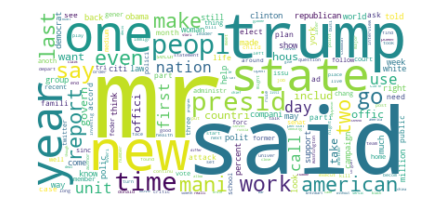

In [44]:
# cria nuvem de palavras mais frequentes para as notícias consideradas não confiáveis
text = " ".join(str(review) for review in train[train['label']==0]['words_text'])
wordcloud = WordCloud(background_color="white", collocations=False).generate(text)
plt.figure(num=None,  dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

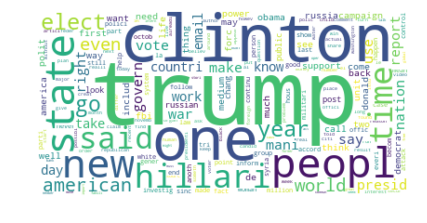

In [45]:
# cria nuvem de palavras mais frequentes para as notícias consideradas confiáveis
text = " ".join(str(review) for review in train[train['label']==1]['words_text'])
wordcloud = WordCloud(background_color="white", collocations=False).generate(text)
plt.figure(num=None,  dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As notícias são da época das eleições presidenciais em que Trump se elegeu. 
É interessante notar que uma das palavras mais frequentes em notícias não confiáveis é "Trump", nome do atual presidente dos Estados Unidos. Enquanto que entre as palavras mais frequente em notícias confiáveis estão os nomes Trump, novamente, e Clinton, sobrenome da outra candidata àquelas eleições. O nome de Clinton aparece na nuvem de palavras das notícias não confiáveis, porém não está entre as mais frequentes. 

In [46]:
# conta as vezes que cada palavra foi utilizada nas notícias, ao longo de todo conjunto de treinamento
count = Counter([i for sublist in train.processed_text for i in sublist])

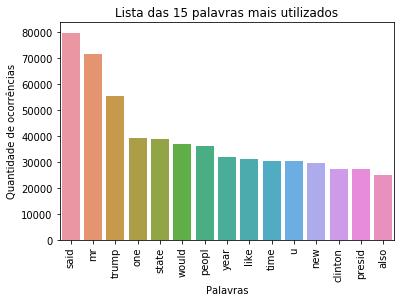

In [47]:
most_common = pd.DataFrame(count.most_common(15))
sns.barplot(most_common[0], most_common[1])
plt.title('Lista das 15 palavras mais utilizados')
plt.xticks(rotation=90)
plt.xlabel('Palavras')
plt.ylabel('Quantidade de ocorrências')
plt.show()

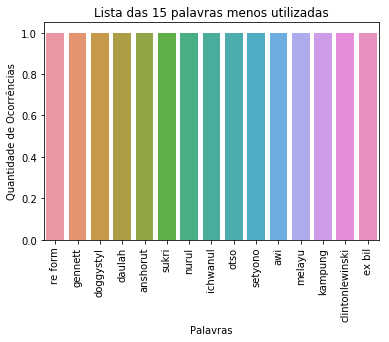

In [48]:
least_common = pd.DataFrame(count.most_common()[:-16:-1])
sns.barplot(least_common[0], least_common[1])
plt.title('Lista das 15 palavras menos utilizadas')
plt.xticks(rotation=90)
plt.xlabel('Palavras')
plt.ylabel('Quantidade de Ocorrências')
plt.show()

## Conclusões da Análise Exploratória

* As colunas `id`, `text` e `title` não serão utilizadas para a criação do modelo. O `id` não será utilizado pois é a coluna de identificação de cada notícia e, portanto, não possui poder de classificação que permita distinguir os exemplos. Já as colunas `text` e `title` possuem o formato original de texto, difícil de ser trabalhado. Como elas passaram por um tratamento e pré-processamento, serão utilizadas as colunas resultantes desse processo.
* As variáveis de contagem de palavras utilizadas nas análises exploratórias serão utilizadas na modelagem, a fim de analisar o seu poder preditivo para o problema.
* As etapas de pré-processamento realizadas nessa análise exploratória serão reaproveitadas na etapa de feature engeneering para limpeza e tratamento do conjunto de dados:
    * Exclusão das notícias repetidas 
    * Conversão de todas as palavras para letras minúsculas
    * Remoção de caracteres númericos e especiais
    * Remoção de stopwords
    * Lematização e stemming das palavras